<a href="https://colab.research.google.com/github/LapTQ/handwritten_text_recognition/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and import

In [1]:
!git clone https://github.com/hungpham13/Vietnamese-HTR.git

!pip install jiwer

Cloning into 'Vietnamese-HTR'...
remote: Enumerating objects: 4825, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 4825 (delta 5), reused 19 (delta 5), pack-reused 4806
Receiving objects: 100% (4825/4825), 462.26 MiB | 39.29 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (4792/4792), done.
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149869 sha256=4992d4b70236bd309fb6269da840e53071b3b806509a68da6e309b939f7d0bc0
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [2]:
import os
import re
import numpy as np
import tensorflow as tf
from jiwer import wer

import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path
import pickle

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Pepare dataset

In [3]:
!head -20 '/content/Vietnamese-HTR/data/Data 1: Handwriting OCR for Vietnamese Address/0825_DataSamples 1/labels.json'

{
    "1.jpg": "Số 3 Nguyễn Ngọc Vũ, Hà Nội",
    "2.jpg": "Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội",
    "3.jpg": "58 Thái Thịnh, Đống Đa, Hà Nội",
    "4.jpeg": "Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai",
    "5.jpg": "Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung",
    "6.jpg": "Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội",
    "7.jpg": "40 Cát Linh, Đống Đa, Hà Nội",
    "8.jpg": "phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm",
    "9.JPG": "Nhà 87 ngõ 416 Đê La Thành",
    "10.JPG": "Up coworking Space, 89 Láng Hạ, Hà Nội",
    "11.jpg": "192 Ngô Đức Kế, quận 1, Hồ Chí Minh",
    "12.jpg": "số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1",
    "13.jpg": "90A đường Mai Xuân Thưởng, tỉnh Gia Lai",
    "14.jpg": "96/7/12B Phạm Văn Đồng, thành phố Pleiku",
    "15.jpg": "168 Ngô Gia Tự, thành phố Hà Tĩnh"
}

In [4]:
train_img_dir = '/content/Vietnamese-HTR/data/Data 1: Handwriting OCR for Vietnamese Address/0916_Data Samples 2'
test_img_dir = '/content/Vietnamese-HTR/data/Data 1: Handwriting OCR for Vietnamese Address/1015_Private Test'

image_height, image_width = 120, 1900
vocab_size = 10000

# Fixed length allowed for any sequence
seq_length = 25

# Dimension for the image embeddings and token embeddings
embedding_dim = 512

# Per-layer units in the feed-forward network
units = 512

batch_size = 8

In [5]:
print('Number of training images:', len(list(Path(train_img_dir).glob('*.png'))))
print('Number of testing images:', len(list(Path(test_img_dir).glob('*.png'))))

Number of training images: 1823
Number of testing images: 549


In [6]:
import json

train_json = json.load(
    open(train_img_dir + '/labels.json', 'r')
)

test_json = json.load(
    open(test_img_dir + '/labels.json', 'r')
)

train_data = {os.path.join(train_img_dir, image_name): '<start> ' + label + ' <end>' for image_name, label in train_json.items()}
test_data = {os.path.join(test_img_dir, image_name): '<start> ' + label + ' <end>' for image_name, label in test_json.items()}

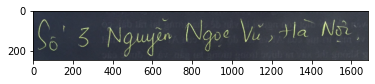

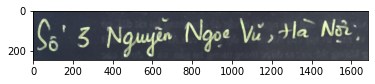

In [7]:
def dilate_batch(img_batch, repeats=1):
    kernel = tf.ones((3, 3, 3), dtype=img_batch.dtype)
    for _ in range(repeats):
        img_batch = tf.nn.dilation2d(
            img_batch,
            filters=kernel,
            strides=(1, 1, 1, 1),
            padding='SAME',
            data_format='NHWC',
            dilations=(1, 1, 1, 1)
        )
        img_batch = img_batch - tf.ones_like(img_batch)
    return img_batch

path = '/content/Vietnamese-HTR/data/Data 1: Handwriting OCR for Vietnamese Address/0825_DataSamples 1/1.jpg'
img = plt.imread(path)
img = 255 - img
plt.imshow(img)
plt.show()
img = dilate_batch(tf.expand_dims(img, axis=0), repeats=3)[0]
plt.imshow(img)
plt.show()

In [8]:
def decode_and_resize(img_path):
    img_string = tf.io.read_file(img_path)
    img = tf.image.decode_png(img_string)

    # invert color      ##############################
    img = 255 - img
    
    # resize to desired shape
    # input is of int [0, 255], but output is of float [0, 255]
    img = tf.image.resize_with_pad(img, image_height, image_width)

    # preprocess_input accept input of type float [0, 255]
    # img = tf.cast(img, tf.int32)
    img = dilate_batch(tf.expand_dims(img, axis=0), repeats=2)[0]
    img = keras.applications.densenet.preprocess_input(img)

    return img

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace('<', '')
strip_chars = strip_chars.replace('>', '')
strip_chars = strip_chars.replace('/', '')
strip_chars = strip_chars.replace('-', '')

vectorization = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_length,
    standardize=lambda label: tf.strings.regex_replace(label, "[%s]" % re.escape(strip_chars), "")
)

vectorization.adapt(list(train_data.values()))

def preprocess_input(img_path, label):
    return decode_and_resize(img_path), vectorization(label)

def make_dataset(img_paths, labels, training):
    assert training is True or training is False

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=2000)
    # dataset = dataset.cache()
    if training: 
        dataset = dataset.shuffle(buffer_size=2000)
    dataset = dataset.batch(batch_size)

    return dataset


train_ds = make_dataset(
    train_data.keys(),
    train_data.values(),
    training = True
)
test_ds = make_dataset(
    test_data.keys(),
    test_data.values(),
    training = False
)

In [9]:
word_to_index = keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary())
index_to_word = keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary(),
    invert=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


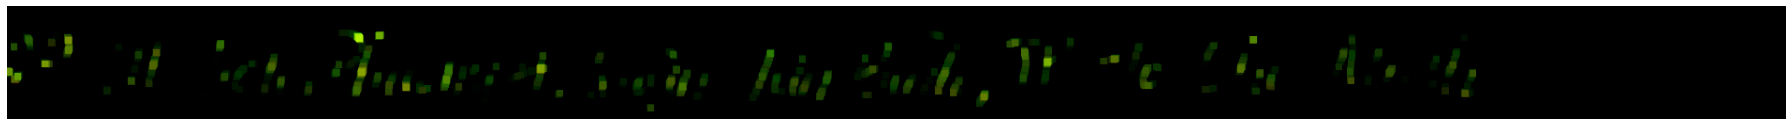

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


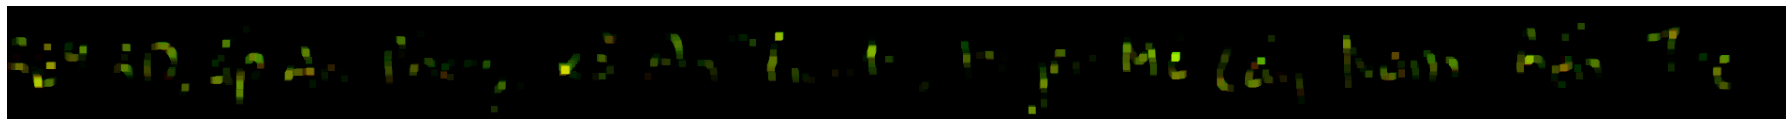

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


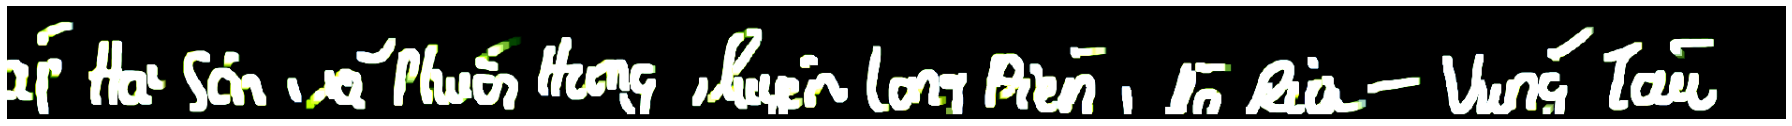

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


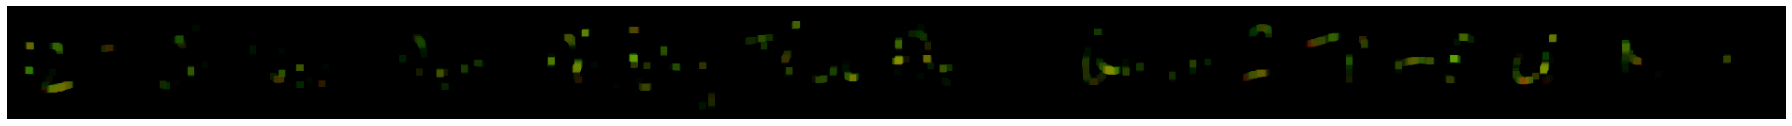

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


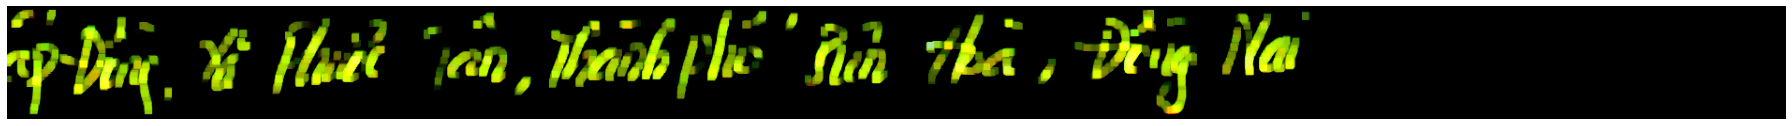

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


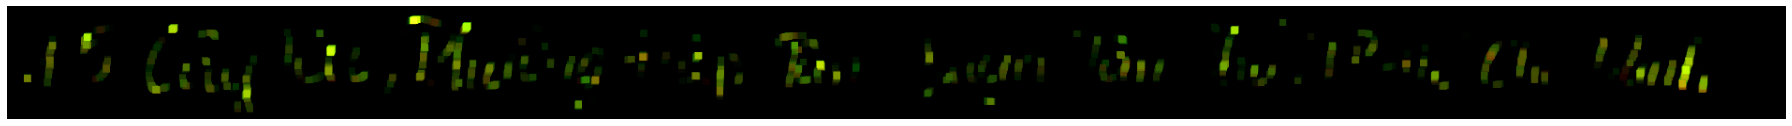

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


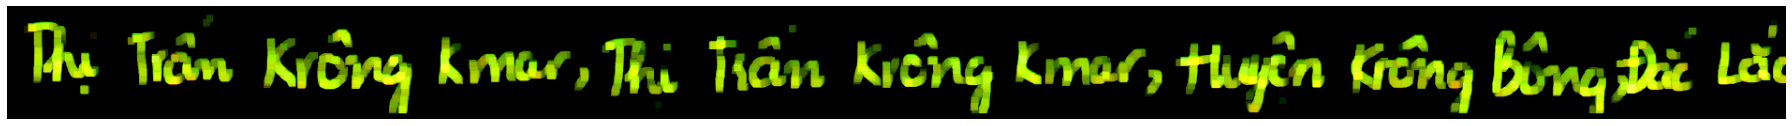

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


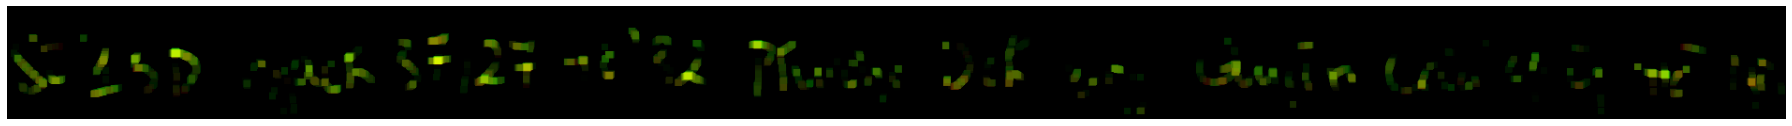

In [ ]:
for images, labels in train_ds.take(1):
    for image, label in zip(images, labels):
        plt.figure(figsize=(25, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        # print(label)

## Build model

In [18]:
base_cnn = keras.applications.DenseNet121(
            include_top=False,
            input_shape=(image_height, image_width, 3),
)

output = base_cnn.output
# squash the feature map from shape [batch_size, f_height, f_width, f_channel]
# to shape [batch_size, f_width, f_height x f_channel]
output = keras.layers.Permute((2, 1, 3))(output)
output = keras.layers.Reshape((-1, output.shape[-1] * output.shape[-2]))(output)
# shape after dense == (batch_size, f_width, embedding_dim)
output = keras.layers.Dense(embedding_dim)(output)
output = keras.layers.ReLU()(output)

encoder = keras.Model(base_cnn.input, output)

In [17]:
a = tf.constant(
    [[[[1, 2, 3],
      [4, 5, 6],
      [7, 8, 9]],
     [[10, 11, 12],
      [13, 14, 15],
      [16, 17, 18]],
     ]]
)
b = keras.layers.Permute((2, 1, 3))(a)
b = keras.layers.Reshape((-1, b.shape[-1] * b.shape[-2]))(b)
b

<tf.Tensor: shape=(1, 3, 6), dtype=int32, numpy=
array([[[ 1,  2,  3, 10, 11, 12],
        [ 4,  5,  6, 13, 14, 15],
        [ 7,  8,  9, 16, 17, 18]]], dtype=int32)>

In [11]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape = (batch_size, f_width, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, f_width, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, f_width, 1)
        # this gives an unnormalized score for each image feature
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, f_width, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context vector shape after sum = (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


Bahdanau vs Luong

In [20]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # print('RNN_Decoder: context_vector.shape == ', context_vector.shape)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [21]:
# encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vectorization.vocabulary_size())

In [22]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(trues, preds):
    loss_ = loss_object(trues, preds)
    
    mask = tf.cast(
        tf.math.logical_not(tf.math.equal(trues, 0)),
        dtype=loss_.dtype
    )

    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
!mkdir checkpoints
!mkdir checkpoints/train

In [24]:
checkpoint_path = 'checkpoints/train'
ckpt = tf.train.Checkpoint(
    encoder=encoder,
    decoder=decoder,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep=5
)
start_epoch = 0

In [25]:
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [26]:
loss_plot = []
wer_plot = []

In [27]:
@tf.function
def train_step(images, targets):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=targets.shape[0])

    dec_input = tf.expand_dims(
        [word_to_index('<start>')] * targets.shape[0],
        axis=1
    )

    with tf.GradientTape() as tape:
        features = encoder(images)

        for i in range(1, targets.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(targets[:, i], predictions)

            dec_input = tf.expand_dims(targets[:, i], 1)
    
    total_loss = loss / targets.shape[1]

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [28]:
def predict(images):
    # images shape == (batch_size, height, width, channels)

    # features shape == (batch_size, f_width, f_height x f_channels)
    features = encoder(images)

    hidden = decoder.reset_state(batch_size=images.shape[0])

    results = tf.expand_dims([word_to_index('<start>')] * images.shape[0], axis=1)

    for i in range(seq_length):
        predictions, hidden, attention_weights = decoder(
            results[..., -1:], #(4, 1)
            features,
            hidden
        )

        predicted_id = tf.expand_dims(
            tf.argmax(predictions, axis=-1),
            axis=-1
        )

        results = tf.concat([results, predicted_id], axis=-1) # tf.expand_dims(predicted_id, 0)
        
    return results

def evaluate(images, targets):
    # images shape == (batch_size, height, width, channels)
    results = predict(images)
    true_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:-1] if i.numpy() != 0 and i != word_to_index('<end>')])
        for j in targets]
    pred_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:] if i != word_to_index('<end>')])
        for j in results]
    
    return wer(true_texts, pred_texts)

## Train

In [ ]:
# tf.config.run_functions_eagerly(False)

Epoch: 1 Batch: 0 Loss: 4.2637
Epoch: 1 Batch: 50 Loss: 3.1352
Epoch: 1 Batch: 100 Loss: 3.4892
Epoch: 1 Batch: 150 Loss: 2.8692
Epoch: 1 Batch: 200 Loss: 3.2855
Epoch: 1 Loss: 3.226279
Time taken for 1 epoch 236.85 sec



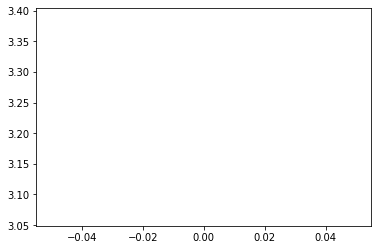

Epoch: 1 Batch: 0 WER: 1.00
Epoch: 1 Batch: 50 WER: 1.00
Epoch: 1 WER: 1.00


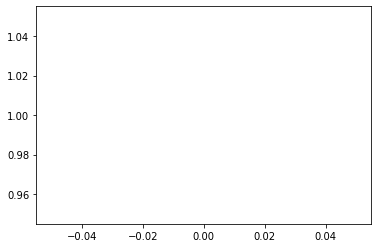

Epoch: 2 Batch: 0 Loss: 3.0781
Epoch: 2 Batch: 50 Loss: 2.8513
Epoch: 2 Batch: 100 Loss: 3.1615
Epoch: 2 Batch: 150 Loss: 3.0408
Epoch: 2 Batch: 200 Loss: 2.9536
Epoch: 2 Loss: 2.988920
Time taken for 1 epoch 158.46 sec



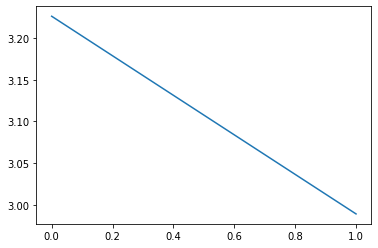

Epoch: 2 Batch: 0 WER: 1.00


KeyboardInterrupt: ignored

In [29]:
import time

epochs = 10

for epoch in range(start_epoch, epochs):
    start = time.time()
    total_loss = 0

    for batch, (images, targets) in enumerate(train_ds):

        batch_loss, t_loss = train_step(images, targets)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy() / int(targets.shape[1])
            print(f'Epoch: {epoch + 1} Batch: {batch} Loss: {average_batch_loss:.4f}')

    loss_plot.append(total_loss / train_ds.cardinality().numpy())

    print(f'Epoch: {epoch + 1} Loss: {total_loss/train_ds.cardinality().numpy():.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

    plt.plot(loss_plot)
    plt.show()

    total_wer = 0
    for batch, (images, targets) in enumerate(test_ds):
        batch_wer = evaluate(images, targets)
        total_wer += batch_wer

        if batch % 50 == 0:
            print(f'Epoch: {epoch + 1} Batch: {batch} WER: {batch_wer:.2f}')
    
    wer_plot.append(total_wer / test_ds.cardinality().numpy())

    print(f'Epoch: {epoch + 1} WER: {total_wer/test_ds.cardinality().numpy():.2f}')

    plt.plot(wer_plot)
    plt.show()
    

    if epoch % 5 == 0:
        ckpt_manager.save()

 A WER of 5-10% is considered to be good quality and is ready to use. A WER of 20% is acceptable, but you might want to consider additional training. A WER of 30% or more signals poor quality and requires customization and training.

## Save model

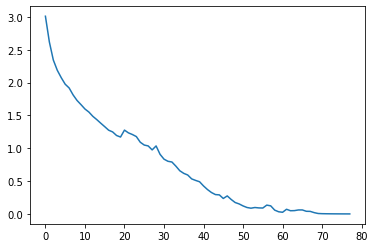

In [ ]:
plt.plot(loss_plot)

In [ ]:
# save checkpoint
!tar -czf drive/MyDrive/checkpoint/htr/checkpoints2.tar.gz ./checkpoints

In [ ]:
with open('drive/MyDrive/checkpoint/htr/loss_plot2.pkl', 'wb') as f:
    pickle.dump(loss_plot, f)

with open('drive/MyDrive/checkpoint/htr/wer_plot2.pkl', 'wb') as f:
    pickle.dump(wer_plot, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract checkpoint archive
!tar -xf drive/MyDrive/checkpoint/htr/checkpoints.tar.gz -C ./

In [ ]:
# load checkpoint
ckpt_path = tf.train.latest_checkpoint(checkpoint_path)
ckpt.restore(ckpt_path)

In [ ]:
with open('drive/MyDrive/checkpoint/htr/loss_plot.pkl', 'rb') as f:
    loss_plot = pickle.load(f)

with open('drive/MyDrive/checkpoint/htr/wer_plot.pkl', 'wb') as f:
    pickle.dump(wer_plot, f)

In [38]:
for images, targets in test_ds:
    preds = predict(images)
    true_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:-1] if i.numpy() != 0 and i != word_to_index('<end>')])
        for j in targets]
    pred_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:] if i != word_to_index('<end>')])
        for j in preds]
    print(preds)
    for pred, target in zip(pred_texts, true_texts):
        # plt.figure(figsize=(15, 3))
        # plt.imshow(1 - image)
        # plt.show()
        
        print("True:", target)
        print('Pred:', pred)
    break

tf.Tensor(
[[2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]], shape=(8, 26), dtype=int64)
True: Số 10 đường Lý Văn Lâm Phường 1 Thành Phố Cà Mau Cà Mau
Pred: 
True: 271 Huỳnh Ngọc Huệ Phường Hoà Khê Quận Thanh Khê Đà Nẵng
Pred: 
True: Số [UNK] KP 9 Phường Hố Nai Thành Phố Biên Hoà Đồng Nai
Pred: 
True: Số [UNK] tổ 8 ấp Tân Hòa Xã Tân Tiến Huyện Bù Đốp Bình Phước
Pred: 
True: Số 47 tổ [UNK] khu 1 Phường Gia Cẩm Thành phố Việt Trì Phú Thọ
Pred: 
True: Thôn Cầu [UNK] Xã Thanh Xuân Huyện Sóc Sơn Hà Nội
Pred: 
True: 35 Ni Sư Huỳnh Liên Phường 10 Quận Tân Bình TP Hồ Chí Minh
Pred: 
True: Số 33 Trần Cao Vân P

In [ ]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(60, 12))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (3, 59))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(1 - image / tf.reduce_max(image))
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


In [ ]:
for images, targets in train_ds:
    for image, target in zip(images, targets):
        result, attention_plot = evaluate(image)
        plot_attention(image, result, attention_plot)
        print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
        print('Pred:', ' '.join(result))
    break

0.7592592592592593


In [ ]:
print(true_texts)
print(pred_texts)

['Số 10 đường Lý Văn Lâm Phường 1 Thành Phố Cà Mau Cà Mau', '271 Huỳnh Ngọc Huệ Phường Hoà Khê Quận Thanh Khê Đà Nẵng', 'Số [UNK] KP 9 Phường Hố Nai Thành Phố Biên Hoà Đồng Nai', 'Số [UNK] tổ 8 ấp Tân Hòa Xã Tân Tiến Huyện Bù Đốp Bình Phước']
['Số nhà 71 phố 4 Phường Tân Tiến Thành phố Đồng Hới Quảng Trị', '729 âu Cơ Phường Thanh Khê Đông Quận Thanh Khê Đà Nẵng', 'Số 79 tổ 23 Phường Khương Đình Quận Cầu Giấy Hà Nội', 'Số 79 ngõ 328 Lê Lợi Xã Diên Khánh Huyện Diên Khánh Hà Nội']


In [ ]:
for image, target in zip(images, targets):
    result, attention_plot = evaluate(image)
    print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
    print('Pred:', ' '.join(result))

True: <start> Khu 3 Xã Cát Quế Huyện Hoài Đức Hà Nội <end>
Pred: Khu 3 Xã Cát Quế Huyện Hoài Đức Hà Nội <end>
True: <start> Số 79 Đường số 37 Khu phố 2 Phường 10 Quận 6 TP Hồ Chí Minh <end>
Pred: Số 79 Đường số 37 Khu phố 2 Phường 10 Quận 6 TP Hồ Chí Minh <end>
True: <start> Số 25 Nguyễn Bỉnh Khiêm Phường 8 Thành phố Cà Mau Cà Mau <end>
Pred: Số 25 Nguyễn Bỉnh Khiêm Phường 8 Thành phố Cà Mau Cà Mau <end>
True: <start> 271/7B An Dương Vương Phường 03 Quận 5 TP Hồ Chí Minh <end>
Pred: 271/7B An Dương Vương Phường 03 Quận 5 TP Hồ Chí Minh <end>


https://www.tensorflow.org/tutorials/text/image_captioning

https://www.tensorflow.org/text/tutorials/nmt_with_attention

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_captioning.ipynb#scrollTo=StQK3dgDcri0

https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

https://keras.io/examples/nlp/semantic_similarity_with_bert/


## References
1. https://arxiv.org/pdf/1703.09137.pdf
2. https://viblo.asia/p/a-guide-to-image-captioning-part-1-gioi-thieu-bai-toan-sinh-mo-ta-cho-anh-gAm5yr88Kdb
3. https://www.tensorflow.org/tutorials/text/image_captioning
4. https://arxiv.org/pdf/1502.03044.pdf
5. https://keras.io/examples/vision/image_captioning/
6. https://machinelearningmastery.com/the-bahdanau-attention-mechanism/
7. https://keras.io/examples/audio/ctc_asr/